<a href="https://colab.research.google.com/github/nsandlin1/EEG_Mining/blob/main/EEG_Mining_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link to data files: https://bbci.de/competition/iii/#data_set_v

# Setting up data files

### Refactor from ascii (.asc) to csv (.csv)

```
perl -i -pe 's/(?<=\d)   (?=\d)/,/g' train*
perl -i -pe 's/^   //g' train*

perl -i -pe 's/(?<=\d)  (?=\d)/,/g' test*
perl -i -pe 's/^  //g' test*

for FILENAME in *.asc; do mv "$FILENAME" "${FILENAME%.asc}"; done
for FILENAME in *; do mv "$FILENAME" "${FILENAME}.csv"; done
```

### Import files

In [4]:
# upload files
from google.colab import files
uploaded = files.upload()

Saving train_subject1_psd01.csv to train_subject1_psd01.csv
Saving train_subject1_psd02.csv to train_subject1_psd02.csv
Saving train_subject1_psd03.csv to train_subject1_psd03.csv


In [5]:
# import files to pd dataframe
import pandas as pd
train_subject1_psd01 = pd.read_csv('train_subject1_psd01.csv', header=None)
train_subject1_psd02 = pd.read_csv('train_subject1_psd02.csv', header=None)
train_subject1_psd03 = pd.read_csv('train_subject1_psd03.csv', header=None)
train_subject1 = pd.concat([train_subject1_psd01, train_subject1_psd02, train_subject1_psd03])
# train_subject2_psd01 = pd.read_csv('train_subject2_psd01.csv', header=None)
# train_subject2_psd02 = pd.read_csv('train_subject2_psd02.csv', header=None)
# train_subject2_psd03 = pd.read_csv('train_subject2_psd03.csv', header=None)
# train_subject3_psd01 = pd.read_csv('train_subject3_psd01.csv', header=None)
# train_subject3_psd02 = pd.read_csv('train_subject3_psd02.csv', header=None)
# train_subject3_psd03 = pd.read_csv('train_subject3_psd03.csv', header=None

# Data Visualization

In [6]:
# view general statistics on attributes
train_subject1.describe()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
count,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,...,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000,10528.000000
mean,0.016992,0.021881,0.019270,0.007753,0.005548,0.004874,0.005299,0.005555,0.003700,0.002613,...,0.009948,0.008243,0.006883,0.005811,0.005122,0.004326,0.003711,0.003132,0.002654,4.296353
std,0.011033,0.020523,0.017561,0.005202,0.003749,0.003276,0.003823,0.004525,0.002577,0.001781,...,0.007147,0.005450,0.004623,0.003982,0.003391,0.002892,0.002515,0.002273,0.001912,2.212673
min,0.000311,0.000274,0.000390,0.000095,0.000089,0.000080,0.000100,0.000104,0.000052,0.000055,...,0.000349,0.000128,0.000181,0.000082,0.000135,0.000099,0.000007,0.000086,0.000045,2.000000
25%,0.008970,0.009067,0.007450,0.004030,0.002860,0.002500,0.002600,0.002470,0.001870,0.001330,...,0.005060,0.004217,0.003520,0.002900,0.002590,0.002230,0.001920,0.001540,0.001320,2.000000
50%,0.014500,0.015600,0.013500,0.006480,0.004670,0.004130,0.004410,0.004360,0.003060,0.002170,...,0.008250,0.007005,0.005840,0.004880,0.004350,0.003630,0.003120,0.002530,0.002180,3.000000
75%,0.022200,0.027000,0.024700,0.010200,0.007220,0.006350,0.006940,0.007300,0.004880,0.003440,...,0.012800,0.010900,0.009050,0.007740,0.006880,0.005752,0.004860,0.004120,0.003490,7.000000
max,0.102000,0.174000,0.130000,0.042800,0.030000,0.032500,0.040000,0.055200,0.026700,0.016200,...,0.079800,0.041400,0.039100,0.035600,0.024300,0.026100,0.020300,0.025300,0.016000,7.000000


<Axes: >

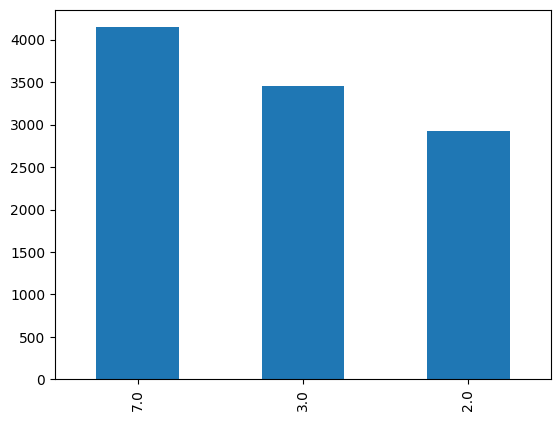

In [7]:
# view occurance of different actions
# actions are specified by column 97
train_subject1[96].value_counts().plot(kind='bar')

<Axes: xlabel='0'>

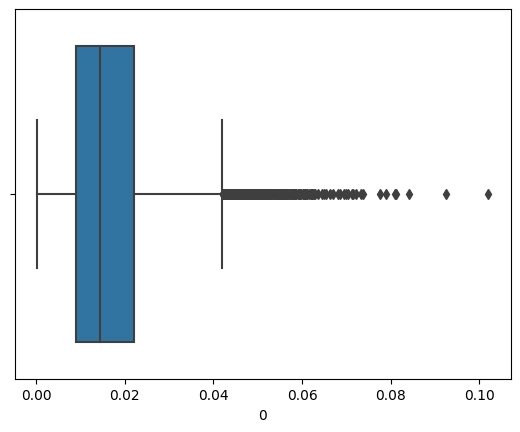

In [8]:
import seaborn as sns
sns.boxplot(data=train_subject1, x=0)

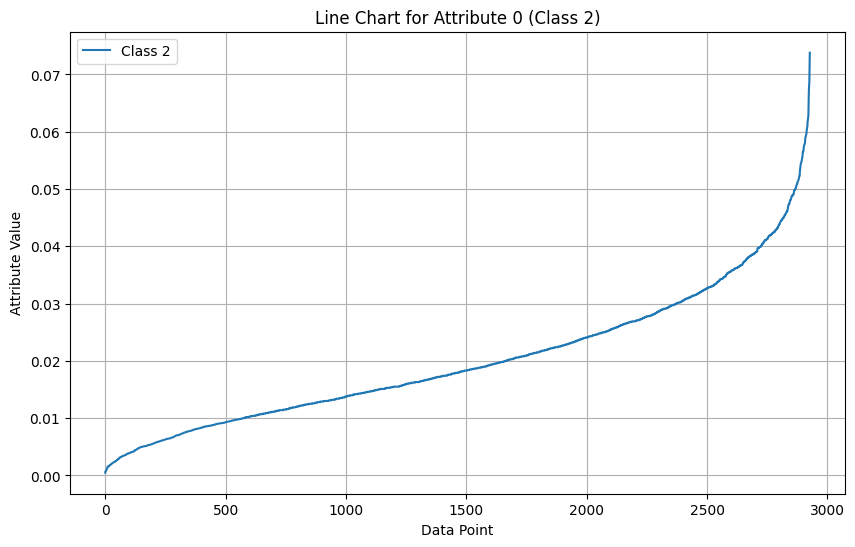

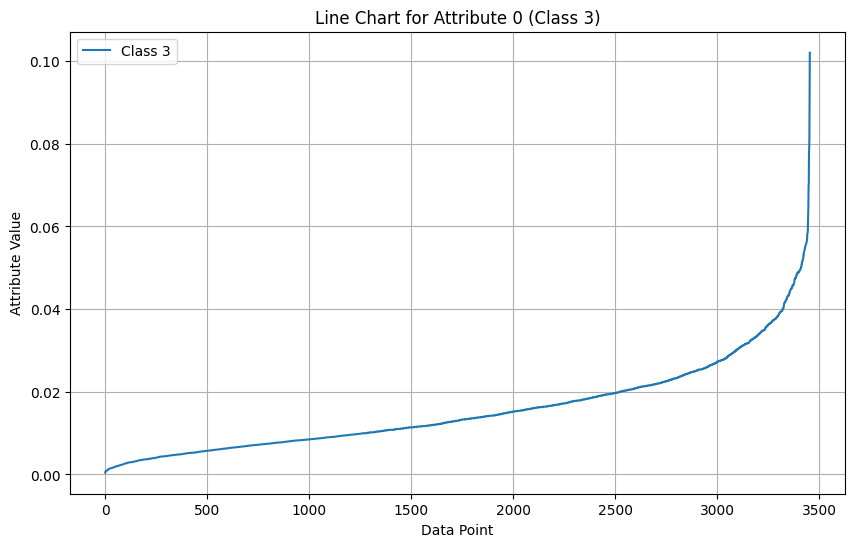

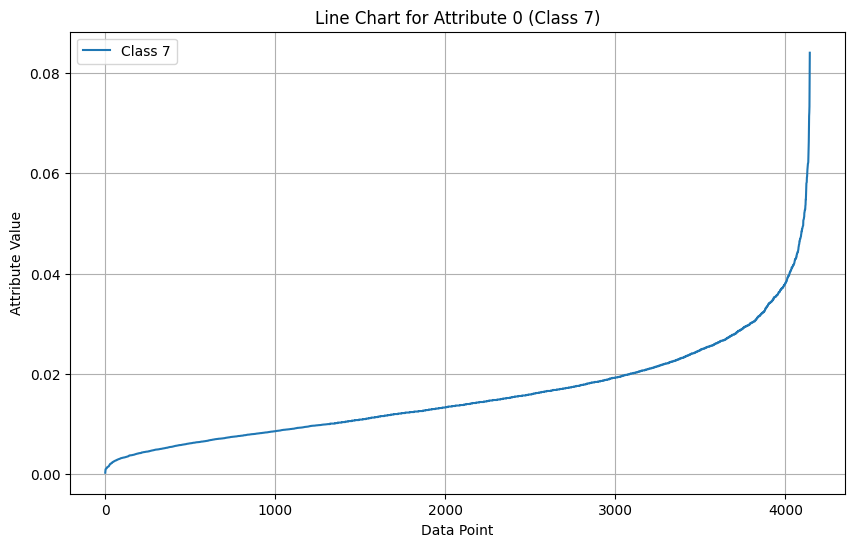

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
data = train_subject1

# Specify the attribute of interest (e.g., the first attribute)
attribute = 0

# Create line charts for each classification
classifications = [2, 3, 7]

for classification in classifications:
    # Filter the data for the selected classification and attribute
    subset = data[data[96] == classification]
    subset = subset.sort_values(by=attribute)  # Sort by the specified attribute
    x_values = range(len(subset))
    y_values = subset[attribute]

    # Create a line chart for the sorted data of the selected classification and attribute
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, label=f'Class {classification}')
    plt.title(f'Line Chart for Attribute {attribute} (Class {classification})')
    plt.xlabel('Data Point')
    plt.ylabel('Attribute Value')
    plt.legend()
    plt.grid(True)
    plt.show()



KeyboardInterrupt: ignored

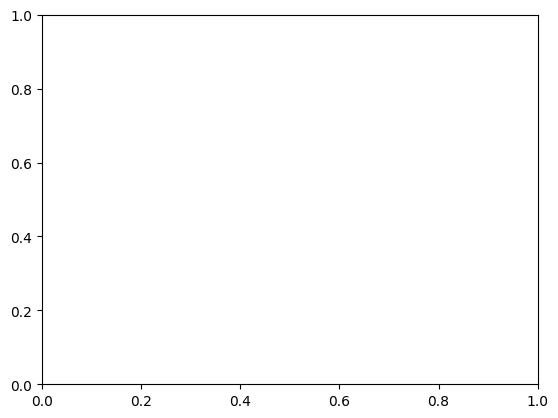

In [10]:
# print distribution of the first attribute accross all measurements (rows)
sns.lineplot(data=train_subject1, x=train_subject1.index, y=train_subject1[0])

### Correlation Table

In [11]:
# linear correlation
train_subject1.corr(method='pearson')

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,1.000000,0.368647,0.190397,0.178495,0.169621,0.191776,0.208910,0.161272,0.122758,0.128234,...,0.083956,0.074993,0.049993,0.084632,0.123674,0.106151,0.119901,0.121011,0.127419,-0.113639
1,0.368647,1.000000,0.792111,0.156609,0.086487,0.153399,0.394778,0.471468,0.212944,0.080792,...,0.024819,0.039828,-0.023670,0.013175,0.029127,0.020919,0.047705,0.058186,0.051735,-0.289722
2,0.190397,0.792111,1.000000,0.417825,0.095010,0.158787,0.299834,0.466793,0.312165,0.126372,...,0.085615,0.091506,0.024189,0.081390,0.097151,0.072840,0.086358,0.091529,0.103051,-0.372905
3,0.178495,0.156609,0.417825,1.000000,0.431242,0.182869,0.152601,0.168235,0.191810,0.125190,...,0.127781,0.117409,0.109730,0.152920,0.169483,0.154832,0.150465,0.129198,0.171594,-0.142574
4,0.169621,0.086487,0.095010,0.431242,1.000000,0.525184,0.157259,0.138539,0.123068,0.114927,...,0.117690,0.165952,0.156312,0.161305,0.163217,0.164586,0.183532,0.192817,0.211920,-0.140470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.106151,0.020919,0.072840,0.154832,0.164586,0.119971,0.081669,0.092419,0.111939,0.115546,...,0.188854,0.199928,0.192377,0.198844,0.547296,1.000000,0.562860,0.248727,0.211903,-0.135669
93,0.119901,0.047705,0.086358,0.150465,0.183532,0.145439,0.092736,0.112023,0.133567,0.144921,...,0.214101,0.201322,0.198271,0.201022,0.241106,0.562860,1.000000,0.576111,0.263031,-0.178726
94,0.121011,0.058186,0.091529,0.129198,0.192817,0.167324,0.066428,0.084283,0.125153,0.171579,...,0.186280,0.165713,0.209512,0.239504,0.222393,0.248727,0.576111,1.000000,0.566022,-0.158935
95,0.127419,0.051735,0.103051,0.171594,0.211920,0.181444,0.079206,0.116219,0.166955,0.156883,...,0.148662,0.189869,0.220499,0.248664,0.219476,0.211903,0.263031,0.566022,1.000000,-0.155802


# Preprocessing

In [12]:
# function for checking nulls in df
def check_for_nulls(df, verbose=False):
  nulls = df.isnull().sum()

  if verbose:
    zeros = {}
    for key,value in nulls.items():
        zeros[key] = value
    return zeros
  else:
    return nulls

In [13]:
check_for_nulls(train_subject1_psd01)

0     0
1     0
2     0
3     0
4     0
     ..
92    0
93    0
94    0
95    0
96    0
Length: 97, dtype: int64

### Analysis of Multicolinearity

In [14]:
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

# Ideal cutoff is ~(5-10)
# TODO: make cutoff ranges into vector given min/max.
#       I think I am receiving low scores on reducted models
#       becuase I am excising too many attributes

from statsmodels.stats.outliers_influence import variance_inflation_factor

# dataframe for independent variables
independents = train_subject1_psd01[[i for i in range(0, 96)]]

# VIF dataframe
vifs = pd.DataFrame()

# calculate VIF for each attribute
vifs["VIF"] = [variance_inflation_factor(independents.values, i) for i in range(len(independents.columns))]

print(vifs[vifs.VIF < 7])
print(vifs[vifs.VIF > 10])

         VIF
0   5.502506
4   6.995330
11  5.826992
12  6.698352
23  5.756081
27  6.670964
35  5.946229
48  6.458289
59  6.399466
60  6.330970
71  6.782178
72  6.700421
83  6.740099
84  6.124534
95  5.188245
          VIF
1   11.381718
2   11.959830
7   10.536628
18  10.791471
25  20.391964
26  14.156629
30  11.755312
37  11.343337
38  11.501331
42  10.832906
43  11.096655
44  10.243611
56  10.136018
57  10.123559
77  10.086936


### Smote-ing the data (equalizing class distribution)

<Axes: >

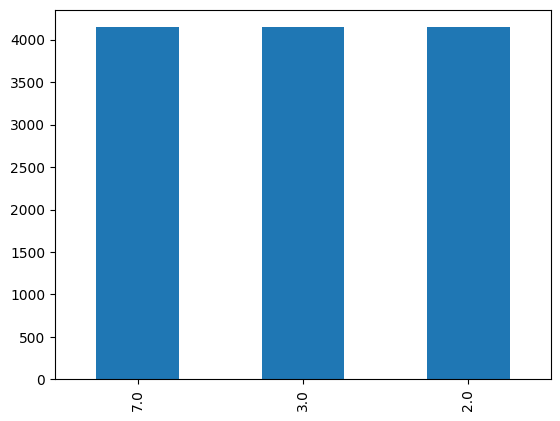

In [15]:
from imblearn.over_sampling import SMOTE

# Synthetic Minority Oversamplting TEcnique
smoter = SMOTE()
X, y = smoter.fit_resample(train_subject1.iloc[:, :96], train_subject1[96])

# join dataframes
smoted_train_subject1 = X.join(y)

# review occurance of different actions
# actions are specified by column 97
smoted_train_subject1[96].value_counts().plot(kind='bar')

# Data Mining

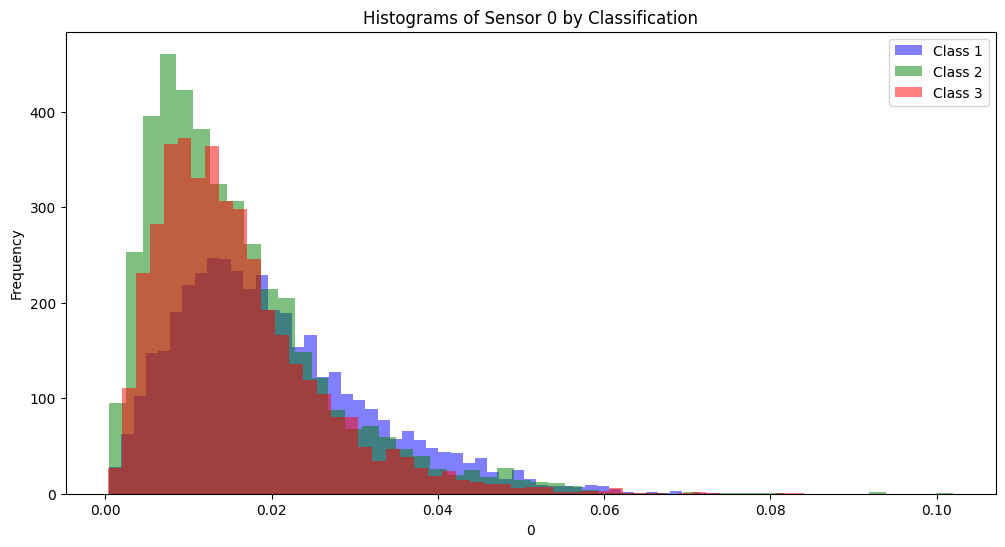

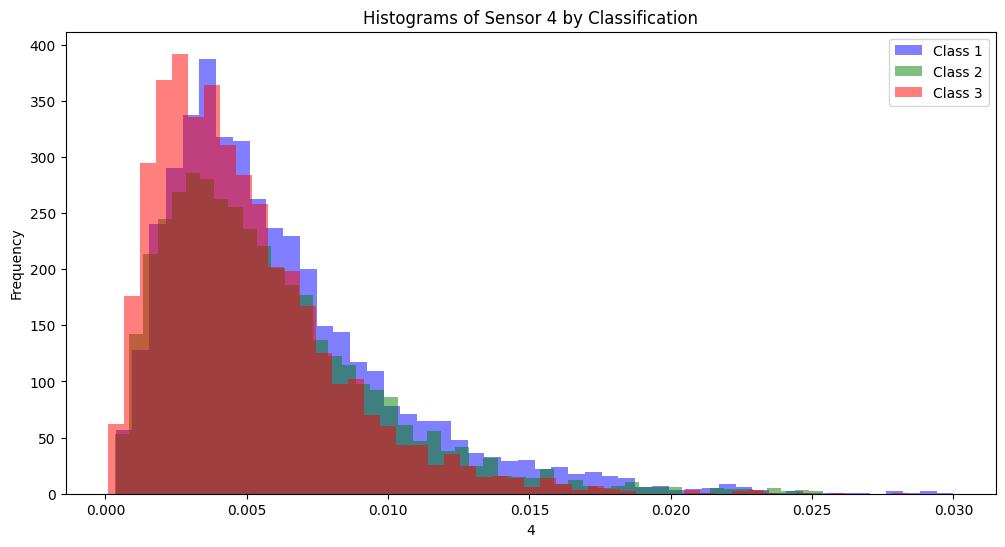

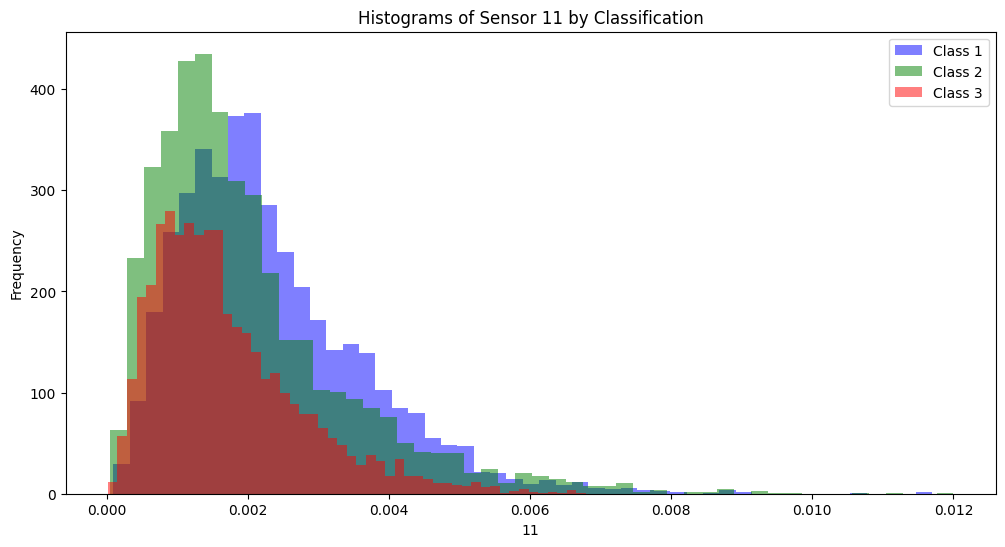

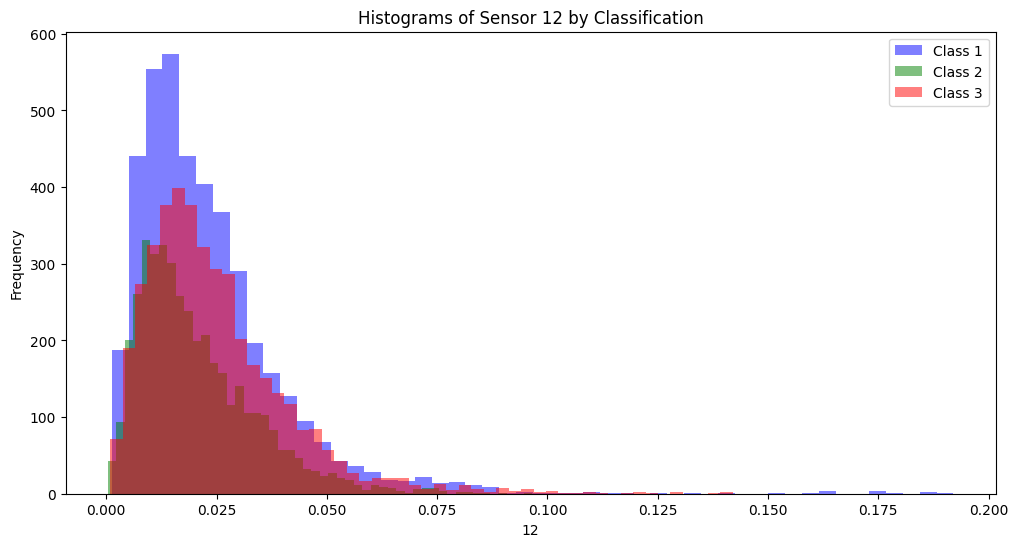

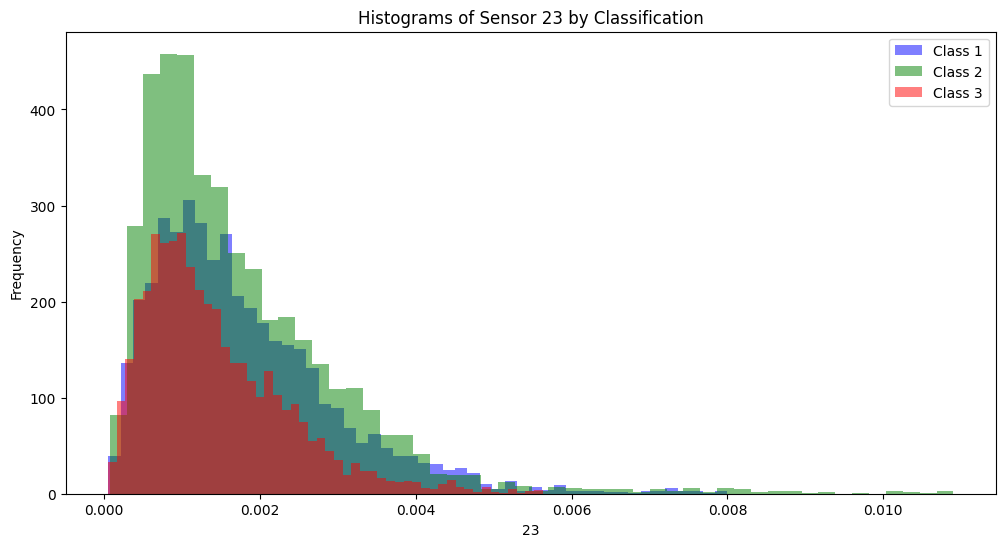

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Separate the data into three classifications (e.g., 'class_1', 'class_2', 'class_3')
class_1_data = smoted_train_subject1[(smoted_train_subject1[96]) == 2]
class_2_data = smoted_train_subject1[(smoted_train_subject1[96]) == 3]
class_3_data = smoted_train_subject1[(smoted_train_subject1[96]) == 7]

for attr in [0,4,11,12,23]:
  # Choose the attribute you want to create histograms for (replace 'attribute_name' with the actual attribute name)
  attribute_name = attr

  # Plot histograms for each classification (change # of bins)
  plt.figure(figsize=(12, 6))
  plt.hist(class_1_data[attribute_name], alpha=0.5, label='Class 1', bins=50, color='blue')
  plt.hist(class_2_data[attribute_name], alpha=0.5, label='Class 2', bins=50, color='green')
  plt.hist(class_3_data[attribute_name], alpha=0.5, label='Class 3', bins=50, color='red')

  # Customize the plot
  plt.xlabel(attribute_name)
  plt.ylabel('Frequency')
  plt.title(f'Histograms of Sensor {attribute_name} by Classification')
  plt.legend(loc='upper right')

  # Show the plot
  plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# define independent and dependent variable subsets for training
independents = train_subject1_psd01.drop(96, axis=1)
dependents = train_subject1_psd01[96]

# partition training and testing sets
ind_train, ind_test, dep_train, dep_test = train_test_split(independents, dependents, test_size=0.2)

# define independent and dependent SMOTEd variable subsets for training
independents = smoted_train_subject1.drop(96, axis=1)
dependents = smoted_train_subject1[96]

# partition training and testing sets SMOTEDd
ind_train_sm, ind_test_sm, dep_train_sm, dep_test_sm = train_test_split(independents, dependents, test_size=0.2)

### Linear Regression

In [18]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

from sklearn.metrics import mean_squared_error, r2_score

# train using all attributes
# instantiate the model
regr_all = LinearRegression()

# regress
regr_all.fit(ind_train, dep_train)

# train using all attributes
dep_pred_all = regr_all.predict(ind_test)

print("all:")
# compute accuracy of model
print("Coefficients: \n", regr_all.coef_)
# mean squared error
print(f"MSE: {mean_squared_error(dep_test, dep_pred_all)}")
# coefficient of determination: 1 is perfect prediction
print(f"r^2: {r2_score(dep_test, dep_pred_all)}")

#####################################################
# Multicolinearity dimensionality reduction failed.
#####################################################

# train using attributes with low multicolinearity as per VIF
# those values with the lowest VIF, < 6, were columns 0, 11, 23, 35, & 95
# constrict training data to those attributes
ind_train_VIF_restricted = ind_train[[0, 11, 23, 35, 95]]
ind_test_VIF_restricted = ind_test[[0, 11, 23, 35, 95]]

# instantiate the model
regr_VIF_restricted = LinearRegression()

# regress
regr_VIF_restricted.fit(ind_train_VIF_restricted, dep_train)

# train using restricted attributes
dep_pred_VIF_restricted = regr_VIF_restricted.predict(ind_test_VIF_restricted)

print("\nVIF restricted:")
# compute accuracy of model
print("Coefficients: \n", regr_VIF_restricted.coef_)
# mean squared error
print(f"MSE: {mean_squared_error(dep_test, dep_pred_VIF_restricted)}")
# coefficient of determination: 1 is perfect prediction
print(f"r^2: {r2_score(dep_test, dep_pred_VIF_restricted)}")


#####################################################
# Regression on SMOTEd values
#####################################################

# instantiate the model
regr_smoted = LinearRegression()

# regress
regr_smoted.fit(ind_train_sm, dep_train_sm)

# train using all SMOTEd attributes
dep_pred_smoted = regr_all.predict(ind_test_sm)

print("all:")
# compute accuracy of model
print("Coefficients: \n", regr_smoted.coef_)
# mean squared error
print(f"MSE: {mean_squared_error(dep_test_sm, dep_pred_smoted)}")
# coefficient of determination: 1 is perfect prediction
print(f"r^2: {r2_score(dep_test_sm, dep_pred_smoted)}")

all:
Coefficients: 
 [144.33830785 130.75609962 105.36012226 177.16043213 117.50013321
 137.61557281 221.98134938  99.28216961 171.31806974 152.8539523
 193.21743663  93.89667214 147.18819408 152.08137871 151.06504791
  92.44483057 112.90235838 198.01339323  65.90326767 242.01414765
  69.01927884 140.01027613 254.95450714 208.75332899 143.23157213
 136.29046441 145.9237679  126.90554715 161.09904498 120.01817446
 160.96533438 103.93396919 190.17641555 122.03835194 138.80949828
  76.31987332 120.97416753 180.15685643 175.32845225 124.53513878
 108.90721992 156.81132236  88.41467076 201.44260391  47.89696024
 231.92604131  56.93089562 171.50439164 129.87846308 180.52803249
 135.94371469 148.5586239   75.53178419 134.63991719 194.2034359
  92.67008716   1.556805   286.58183168  66.10401427 -26.24543879
 137.95813713 138.15613293 134.7612103  148.42341956 136.69191969
 127.68492738 149.26521793 148.17962049 158.42097327  94.89136362
 173.03284993 126.52625586 139.45488605 167.24880292  85.



### Random Forest

acc before not smoted: 1.0
acc not smoted: 0.9570200573065902
acc smoted: 0.9284278246883796


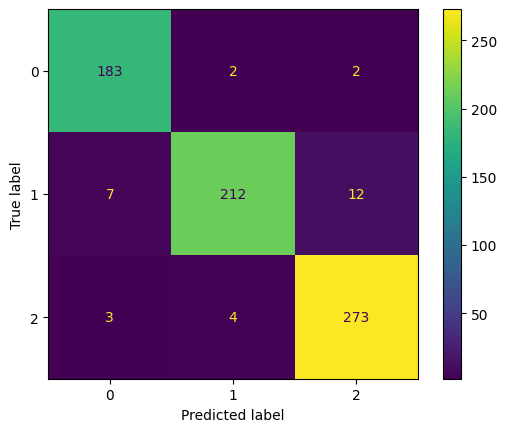

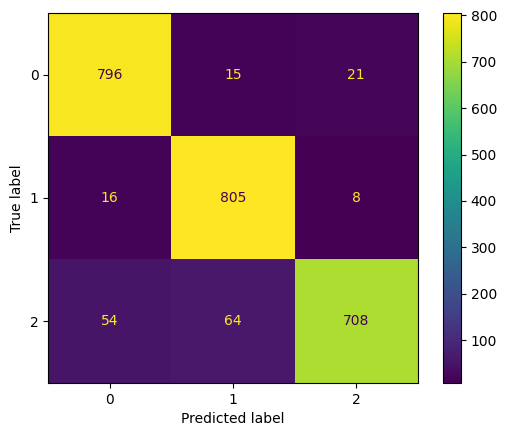

In [19]:
# https://www.datacamp.com/tutorial/random-forests-classifier-python

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# fit the random forest model
##### TODO: Hyperparameter tuning
rf = RandomForestClassifier()
rf.fit(ind_train, dep_train)

# inference on training
dep_pred_train = rf.predict(ind_train)
# compute accuracy training
acc = accuracy_score(dep_train, dep_pred_train)
print(f"acc before not smoted: {acc}")

# inference
dep_pred = rf.predict(ind_test)

# compute accuracy
acc = accuracy_score(dep_test, dep_pred)
print(f"acc not smoted: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test, dep_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

############################################

rf_smoted = RandomForestClassifier()
rf_smoted.fit(ind_train_sm, dep_train_sm)

dep_pred_smoted = rf_smoted.predict(ind_test_sm)

# compute accuracy
acc = accuracy_score(dep_test_sm, dep_pred_smoted)
print(f"acc smoted: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test_sm, dep_pred_smoted)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### SVM

acc: 0.9785100286532952


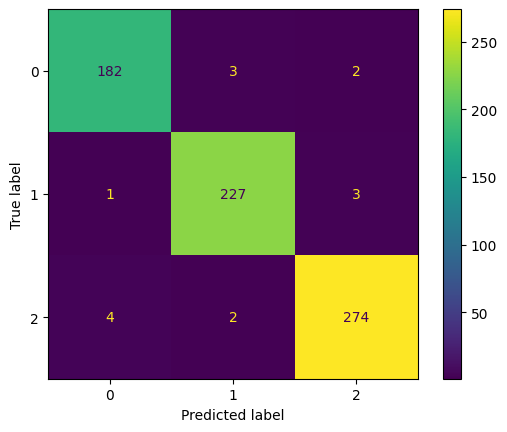

In [20]:
# https://holypython.com/svm/support-vector-machine-step-by-step/#google_vignette

from sklearn import svm

# instantiate svm
sup_vec_mach = svm.SVC(kernel='rbf', gamma=200)

# fit the SVM
sup_vec_mach.fit(ind_train, dep_train)

# inference
dep_pred = sup_vec_mach.predict(ind_test)

# compute accuracy
acc = accuracy_score(dep_test, dep_pred)
print(f"acc: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test, dep_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### Quadratic Discrimination Analysis

acc: 0.9885386819484241
acc: 0.4699140401146132


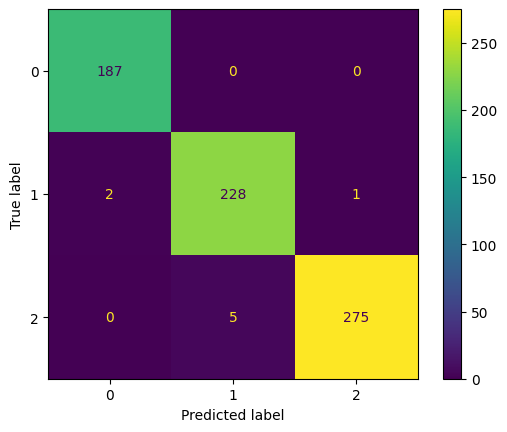

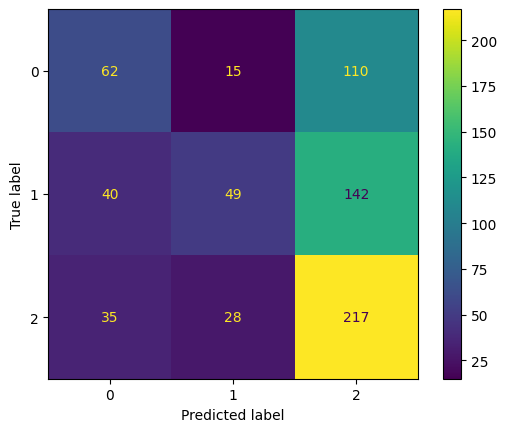

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# without multicolinearity reductions

# define the quadratic discriminator
qd = QuadraticDiscriminantAnalysis()

# fit the model
qd.fit(ind_train, dep_train)

# get predictions
dep_pred = qd.predict(ind_test)

# compute accuracy
acc = accuracy_score(dep_test, dep_pred)
print(f"acc: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test, dep_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# with multicolinearity reductions

# define the quadratic discriminator
qdwmr = QuadraticDiscriminantAnalysis()

# fit the model
qdwmr.fit(ind_train_VIF_restricted, dep_train)

# get predictions
dep_pred_VIF_restricted = qdwmr.predict(ind_test_VIF_restricted)

# compute accuracy
acc = accuracy_score(dep_test, dep_pred_VIF_restricted)
print(f"acc: {acc}")

# print confusion matrix
cm = confusion_matrix(dep_test, dep_pred_VIF_restricted)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()